# DR vs Alternative Methods

**Chapter 12, Section 3**

This notebook compares doubly robust estimation with other approaches and provides practical guidance.

## Table of Contents
1. [Intuition](#intuition) - Method comparison overview
2. [Formal Treatment](#formal) - AIPW connection
3. [Numeric Demonstration](#numeric) - Head-to-head comparison
4. [Implementation](#implementation) - When to use what
5. [Interview Appendix](#interview) - Practice questions

---

In [1]:
# Standard imports
import sys
sys.path.insert(0, '../..')

from facure_augment.common import *
from sklearn.linear_model import LogisticRegression, LinearRegression
from sklearn.neighbors import NearestNeighbors

# Set notebook style
set_notebook_style()

print("Imports complete")

Imports complete


---

## Intuition

### Method Landscape

| Method | Models Needed | Robustness | Efficiency | Transparency |
|--------|---------------|------------|------------|-------------|
| Outcome Regression | Outcome only | Single model | High (if correct) | Medium |
| IPTW | PS only | Single model | Variable | High |
| PS Matching | PS only | Single model | Lower | High |
| **Doubly Robust** | Both | Double | High | Lower |

### When to Use Each

- **Outcome Regression**: Simple relationships, good overlap
- **IPTW**: Transparent weighting, moderate overlap
- **PS Matching**: Maximum transparency, good overlap
- **Doubly Robust**: Model uncertainty, need insurance

---

In [2]:
# Load mindset data
mindset = load_facure_data("learning_mindset.csv")

covariates = [
    'success_expect', 'ethnicity', 'gender', 'frst_in_family',
    'school_mindset', 'school_achievement', 'school_ethnic_minority',
    'school_poverty', 'school_size'
]

X = mindset[covariates].values
T = mindset['intervention'].values
Y = mindset['achievement_score'].values

print(f"Data: {len(mindset)} students")

Data: 10391 students


---

## Formal Treatment

### AIPW Connection

**Augmented IPW (AIPW)** is equivalent to the DR estimator:

$$\hat{\tau}_{AIPW} = \hat{\tau}_{IPW} + \text{Augmentation}$$

Where the augmentation uses outcome model predictions to "stabilize" the IPW estimate.

### Efficiency Bound

When both models are correct, DR achieves the **semiparametric efficiency bound**:

$$V_{DR}^* = E\left[\frac{\sigma_1^2(X)}{e(X)} + \frac{\sigma_0^2(X)}{1-e(X)} + (\mu_1(X) - \mu_0(X) - \tau)^2\right]$$

This is the smallest possible variance among all regular estimators.

### Comparison of Variance

Under correct specification:
- $V_{DR} \leq V_{IPTW}$ (always)
- $V_{DR} \leq V_{OR}$ (when outcome model has error)

---

In [3]:
# Implement all estimators

def outcome_regression_ate(X, T, Y):
    """Pure outcome regression."""
    mu1 = LinearRegression().fit(X[T==1], Y[T==1]).predict(X)
    mu0 = LinearRegression().fit(X[T==0], Y[T==0]).predict(X)
    ate = (mu1 - mu0).mean()
    se = (mu1 - mu0).std() / np.sqrt(len(Y))
    return ate, se

def iptw_ate(X, T, Y):
    """Hajek IPTW estimator."""
    ps = LogisticRegression(C=1e6, max_iter=1000).fit(X, T).predict_proba(X)[:, 1]
    mu1 = np.sum(T * Y / ps) / np.sum(T / ps)
    mu0 = np.sum((1 - T) * Y / (1 - ps)) / np.sum((1 - T) / (1 - ps))
    ate = mu1 - mu0
    # Bootstrap SE would be proper, using simple approx here
    se = np.sqrt(np.var(Y[T==1])/(T.sum()) + np.var(Y[T==0])/((1-T).sum()))
    return ate, se

def ps_matching_ate(X, T, Y):
    """PS matching with replacement."""
    ps = LogisticRegression(C=1e6, max_iter=1000).fit(X, T).predict_proba(X)[:, 1]
    
    # Find nearest PS match for each treated
    treated_idx = np.where(T == 1)[0]
    control_idx = np.where(T == 0)[0]
    
    ps_control = ps[control_idx].reshape(-1, 1)
    nn = NearestNeighbors(n_neighbors=1).fit(ps_control)
    
    matched_effects = []
    for i in treated_idx:
        _, match_idx = nn.kneighbors([[ps[i]]])
        matched_control = control_idx[match_idx[0, 0]]
        matched_effects.append(Y[i] - Y[matched_control])
    
    matched_effects = np.array(matched_effects)
    ate = matched_effects.mean()
    se = matched_effects.std() / np.sqrt(len(matched_effects))
    return ate, se

def doubly_robust_ate(X, T, Y):
    """Doubly robust estimator."""
    ps = LogisticRegression(C=1e6, max_iter=1000).fit(X, T).predict_proba(X)[:, 1]
    mu1 = LinearRegression().fit(X[T==1], Y[T==1]).predict(X)
    mu0 = LinearRegression().fit(X[T==0], Y[T==0]).predict(X)
    
    dr_i = (mu1 - mu0 + 
            T * (Y - mu1) / ps - 
            (1 - T) * (Y - mu0) / (1 - ps))
    
    ate = dr_i.mean()
    se = dr_i.std() / np.sqrt(len(Y))
    return ate, se

---

## Numeric Demonstration

### Head-to-Head Comparison

In [4]:
# Run all estimators
or_ate, or_se = outcome_regression_ate(X, T, Y)
iptw_est, iptw_se = iptw_ate(X, T, Y)
psm_ate, psm_se = ps_matching_ate(X, T, Y)
dr_ate, dr_se = doubly_robust_ate(X, T, Y)

# Naive for reference
naive_ate = Y[T==1].mean() - Y[T==0].mean()

print("METHOD COMPARISON ON MINDSET DATA:")
print("=" * 60)
print(f"{'Method':<25} {'ATE':>10} {'SE':>10} {'95% CI':>20}")
print("-" * 60)
print(f"{'Naive':<25} {naive_ate:>10.4f} {'--':>10} {'--':>20}")
print(f"{'Outcome Regression':<25} {or_ate:>10.4f} {or_se:>10.4f} [{or_ate-1.96*or_se:.3f}, {or_ate+1.96*or_se:.3f}]")
print(f"{'IPTW':<25} {iptw_est:>10.4f} {iptw_se:>10.4f} [{iptw_est-1.96*iptw_se:.3f}, {iptw_est+1.96*iptw_se:.3f}]")
print(f"{'PS Matching':<25} {psm_ate:>10.4f} {psm_se:>10.4f} [{psm_ate-1.96*psm_se:.3f}, {psm_ate+1.96*psm_se:.3f}]")
print(f"{'Doubly Robust':<25} {dr_ate:>10.4f} {dr_se:>10.4f} [{dr_ate-1.96*dr_se:.3f}, {dr_ate+1.96*dr_se:.3f}]")

METHOD COMPARISON ON MINDSET DATA:
Method                           ATE         SE               95% CI
------------------------------------------------------------
Naive                         0.4723         --                   --
Outcome Regression            0.3941     0.0008 [0.392, 0.396]
IPTW                          0.3946     0.0206 [0.354, 0.435]
PS Matching                   0.4072     0.0201 [0.368, 0.447]
Doubly Robust                 0.3949     0.0180 [0.360, 0.430]


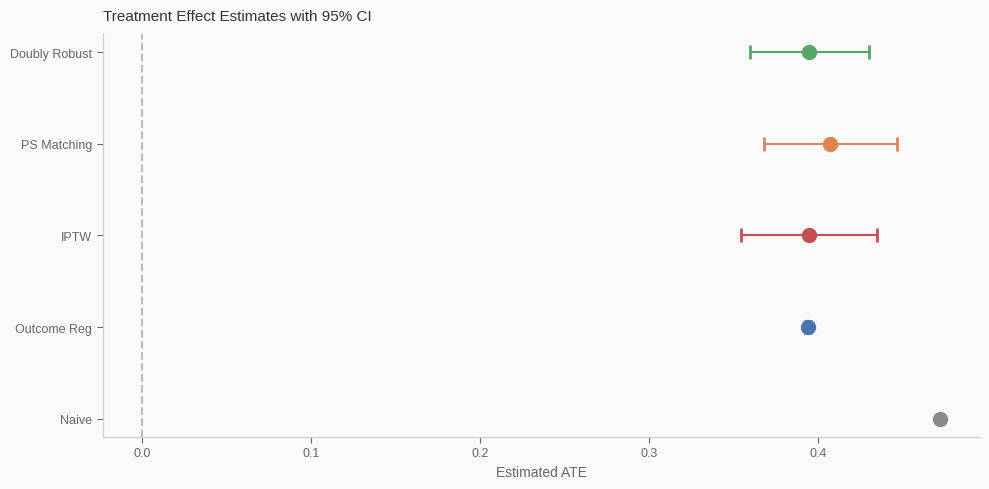

In [5]:
# Visualization
fig, ax = create_tufte_figure(figsize=(10, 5))

methods = ['Naive', 'Outcome Reg', 'IPTW', 'PS Matching', 'Doubly Robust']
estimates = [naive_ate, or_ate, iptw_est, psm_ate, dr_ate]
errors = [0, 1.96*or_se, 1.96*iptw_se, 1.96*psm_se, 1.96*dr_se]
colors_list = [COLORS['gray'], COLORS['blue'], COLORS['red'], COLORS['orange'], COLORS['green']]

y_pos = np.arange(len(methods))

# Plot points with error bars
for i, (est, err, color) in enumerate(zip(estimates, errors, colors_list)):
    ax.errorbar(est, i, xerr=err if err > 0 else None, 
                fmt='o', color=color, markersize=10, capsize=5, capthick=2)

ax.axvline(0, color='gray', linestyle='--', alpha=0.5)
ax.set_yticks(y_pos)
ax.set_yticklabels(methods)

set_tufte_title(ax, "Treatment Effect Estimates with 95% CI")
set_tufte_labels(ax, "Estimated ATE", "")

plt.tight_layout()
plt.show()

### Bootstrap Comparison

In [6]:
# Bootstrap to compare variability
np.random.seed(42)
n_boot = 50  # Reduced for notebook execution speed

boot_results = {
    'Outcome Reg': [],
    'IPTW': [],
    'PS Matching': [],
    'Doubly Robust': []
}

n = len(Y)
for _ in range(n_boot):
    idx = np.random.choice(n, size=n, replace=True)
    X_b, T_b, Y_b = X[idx], T[idx], Y[idx]
    
    boot_results['Outcome Reg'].append(outcome_regression_ate(X_b, T_b, Y_b)[0])
    boot_results['IPTW'].append(iptw_ate(X_b, T_b, Y_b)[0])
    boot_results['PS Matching'].append(ps_matching_ate(X_b, T_b, Y_b)[0])
    boot_results['Doubly Robust'].append(doubly_robust_ate(X_b, T_b, Y_b)[0])

# Summary
print("BOOTSTRAP VARIABILITY COMPARISON:")
print("=" * 60)
print(f"{'Method':<20} {'Mean':>10} {'Std':>10} {'2.5%':>10} {'97.5%':>10}")
print("-" * 60)
for method, values in boot_results.items():
    values = np.array(values)
    print(f"{method:<20} {values.mean():>10.4f} {values.std():>10.4f} "
          f"{np.percentile(values, 2.5):>10.4f} {np.percentile(values, 97.5):>10.4f}")

BOOTSTRAP VARIABILITY COMPARISON:
Method                     Mean        Std       2.5%      97.5%
------------------------------------------------------------
Outcome Reg              0.3905     0.0167     0.3599     0.4205
IPTW                     0.3912     0.0164     0.3607     0.4202
PS Matching              0.4046     0.0343     0.3445     0.4765
Doubly Robust            0.3915     0.0168     0.3610     0.4210


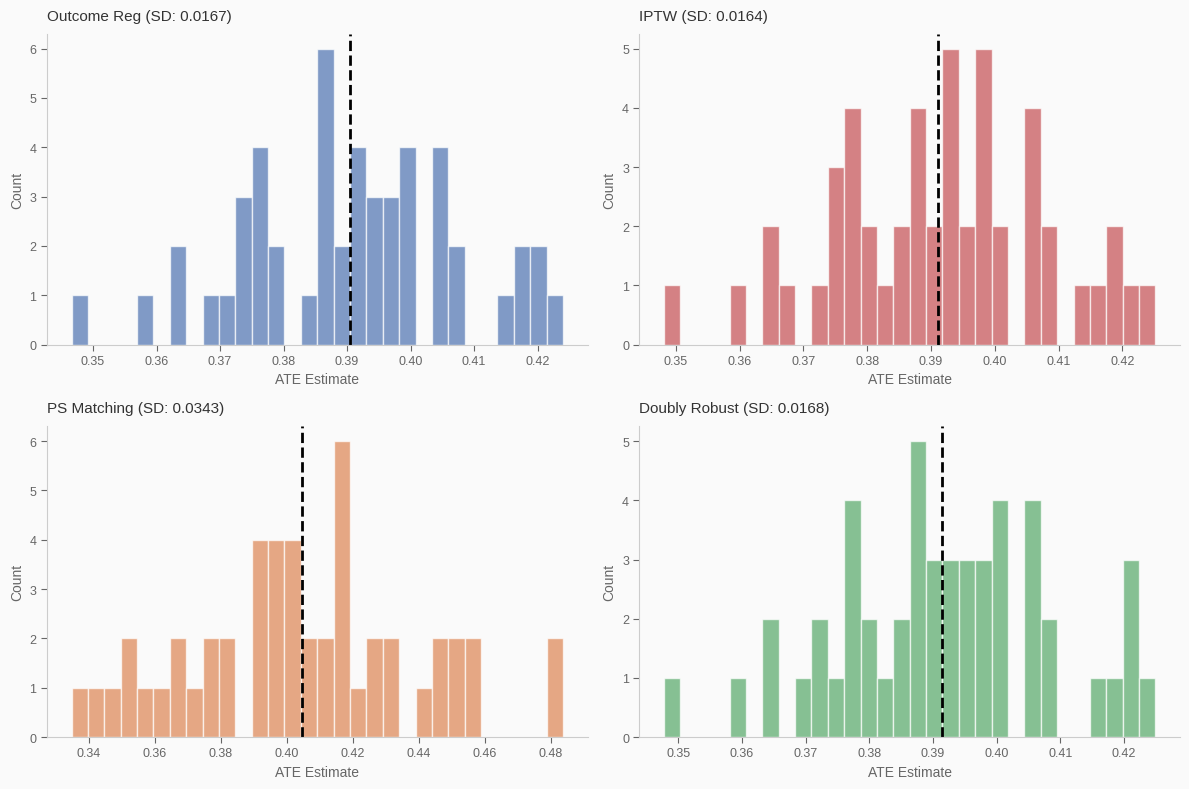

In [7]:
# Visualize bootstrap distributions
fig, axes = create_tufte_figure(ncols=2, nrows=2, figsize=(12, 8))
axes = axes.flatten()

colors_map = {
    'Outcome Reg': COLORS['blue'],
    'IPTW': COLORS['red'],
    'PS Matching': COLORS['orange'],
    'Doubly Robust': COLORS['green']
}

for ax, (method, values) in zip(axes, boot_results.items()):
    values = np.array(values)
    ax.hist(values, bins=30, color=colors_map[method], alpha=0.7, edgecolor='white')
    ax.axvline(values.mean(), color='black', linestyle='--', linewidth=2)
    set_tufte_title(ax, f"{method} (SD: {values.std():.4f})")
    set_tufte_labels(ax, "ATE Estimate", "Count")

plt.tight_layout()
plt.show()

---

## Implementation

### Decision Guide

In [8]:
print("WHEN TO USE EACH METHOD:")
print("=" * 70)
print("""
OUTCOME REGRESSION:
  Best when: Outcome model likely well-specified, good overlap
  Advantages: Simple, interpretable coefficients
  Risks: Extrapolation in poor overlap regions

IPTW:
  Best when: PS model reliable, need transparent weighting
  Advantages: Explicit balance through weights
  Risks: Unstable with extreme weights

PS MATCHING:
  Best when: Need maximum transparency, good overlap
  Advantages: Clear "who is compared to whom"
  Risks: Discards data, lower efficiency

DOUBLY ROBUST:
  Best when: Model uncertainty, need robustness
  Advantages: Double protection, efficient when both correct
  Risks: More complex, can still fail if both wrong

PRACTICAL RECOMMENDATIONS:
  1. Start with outcome regression as baseline
  2. Check overlap with PS diagnostics
  3. Use DR as primary estimate if unsure about model
  4. Report multiple methods for robustness check
  5. If estimates differ substantially, investigate why
""")

WHEN TO USE EACH METHOD:

OUTCOME REGRESSION:
  Best when: Outcome model likely well-specified, good overlap
  Advantages: Simple, interpretable coefficients
  Risks: Extrapolation in poor overlap regions

IPTW:
  Best when: PS model reliable, need transparent weighting
  Advantages: Explicit balance through weights
  Risks: Unstable with extreme weights

PS MATCHING:
  Best when: Need maximum transparency, good overlap
  Advantages: Clear "who is compared to whom"
  Risks: Discards data, lower efficiency

DOUBLY ROBUST:
  Best when: Model uncertainty, need robustness
  Advantages: Double protection, efficient when both correct
  Risks: More complex, can still fail if both wrong

PRACTICAL RECOMMENDATIONS:
  1. Start with outcome regression as baseline
  2. Check overlap with PS diagnostics
  3. Use DR as primary estimate if unsure about model
  4. Report multiple methods for robustness check
  5. If estimates differ substantially, investigate why



In [9]:
# Robustness check summary
all_estimates = [or_ate, iptw_est, psm_ate, dr_ate]
estimate_range = max(all_estimates) - min(all_estimates)
estimate_cv = np.std(all_estimates) / np.mean(all_estimates)

print("ROBUSTNESS CHECK:")
print("=" * 50)
print(f"Estimate range: {estimate_range:.4f}")
print(f"Coefficient of variation: {estimate_cv:.1%}")
print(f"\nAssessment: {'ROBUST - estimates agree' if estimate_cv < 0.2 else 'INVESTIGATE - estimates differ'}")

ROBUSTNESS CHECK:
Estimate range: 0.0131
Coefficient of variation: 1.4%

Assessment: ROBUST - estimates agree


---

## Interview Appendix

### Practice Questions

**Q1: When would you prefer doubly robust over simpler methods?**

<details>
<summary>Solution</summary>

**Use DR when**:
1. You're uncertain about model specification (either PS or outcome)
2. Stakes are high - need robustness as "insurance"
3. You want to combine the strengths of both approaches
4. Sample size allows fitting both models reliably

**Consider simpler methods when**:
1. You're confident in one model specification
2. Transparency is paramount (matching is most interpretable)
3. Sample size is small (fitting two models may overfit)
4. Computation constraints exist

**Best practice**: Report multiple methods and check consistency.

</details>

**Q2: What is the relationship between AIPW and DR?**

<details>
<summary>Solution</summary>

**Answer**: They are equivalent! AIPW = DR = "augmented inverse probability weighting."

**AIPW formulation**:
$$\hat{\tau}_{AIPW} = \underbrace{\frac{1}{n}\sum \frac{T_iY_i}{\hat{e}(X_i)} - \frac{(1-T_i)Y_i}{1-\hat{e}(X_i)}}_{\text{IPW}} + \underbrace{\text{augmentation term}}_{\text{uses outcome model}}$$

**DR formulation**:
$$\hat{\tau}_{DR} = \underbrace{\frac{1}{n}\sum \hat{\mu}_1(X_i) - \hat{\mu}_0(X_i)}_{\text{outcome model}} + \underbrace{\text{IPTW correction}}_{\text{uses PS}}$$

**Key insight**: Same estimator, different decompositions. AIPW starts with IPW and augments; DR starts with outcome model and corrects.

</details>

**Q3: How do you decide between IPTW and matching?**

<details>
<summary>Solution</summary>

**Favor IPTW when**:
- Want to use full sample (more efficient)
- Estimating ATE (matching typically estimates ATT)
- PS model well-specified
- No extreme propensity scores

**Favor Matching when**:
- Want maximum transparency ("these units were compared")
- Estimating ATT
- Extreme weights would dominate IPTW
- Need intuitive explanation for non-technical audience

**Trade-off summary**:
- IPTW: More efficient, less transparent
- Matching: Less efficient, more transparent

</details>

---

## References

[^1]: Facure, M. (2022). *Causal Inference for the Brave and True*, Chapter 12.

[^2]: Lunceford, J. K., & Davidian, M. (2004). Stratification and weighting via the propensity score in estimation of causal treatment effects. *Statistics in Medicine*, 23(19), 2937-2960.

[^3]: Glynn, A. N., & Quinn, K. M. (2010). An introduction to the augmented inverse propensity weighted estimator. *Political Analysis*, 18(1), 36-56.

[^4]: Cross-reference: Double ML in `22_debiased_ml/` extends these ideas with machine learning.